**Install & Import Libraries**

In [30]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn tensorflow openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import datetime
import numpy as np
from io import StringIO
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.impute import SimpleImputer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**Load SECOM Dataset**

In [31]:
import pandas as pd
import numpy as np
from io import StringIO
import os

def load_secom_data():
    print("📁 Loading SECOM dataset locally...")

    data_path = "secom.data"
    label_path = "secom_labels.data"

    if os.path.exists(data_path) and os.path.exists(label_path):
        try:
            df = pd.read_csv(data_path, sep=" ", header=None)
            labels = pd.read_csv(label_path, sep=" ", header=None, usecols=[0])
            labels = labels[0].apply(lambda x: 1 if x == 1 else 0)
            print("✅ Successfully loaded SECOM data from local files.")
            return df, labels
        except Exception as e:
            print(f"❌ Error reading local files: {str(e)}")
    else:
        print("⚠️ Local files not found. Please make sure 'secom.data' and 'secom_labels.data' are in the same folder.")

    # Fallback to small sample data if needed
    print("⚠️ Using sample data (limited functionality)")
    sample_data = "0.1 0.2\n0.3 0.4\n0.5 0.6"
    sample_labels = "-1\n1\n-1"
    df = pd.read_csv(StringIO(sample_data), sep=" ", header=None)
    labels = pd.read_csv(StringIO(sample_labels), header=None, usecols=[0])
    labels = labels[0].apply(lambda x: 1 if x == 1 else 0)
    return df, labels

# Usage
df, labels = load_secom_data()
print("\nData loaded successfully:")
print("Data shape:", df.shape)
print("Labels distribution:\n", labels.value_counts())


📁 Loading SECOM dataset locally...
✅ Successfully loaded SECOM data from local files.

Data loaded successfully:
Data shape: (1567, 590)
Labels distribution:
 0
0    1463
1     104
Name: count, dtype: int64


**Clean & Preprocess Data**

In [32]:
print("\n Cleaning and preprocessing data...")

# Remove columns with too many missing values
df = df.dropna(axis=1, thresh=0.7*len(df))

# Impute remaining missing values with median
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Remove constant features
df_imputed = df_imputed.loc[:, df_imputed.std() > 0.1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_imputed, labels, test_size=0.2, random_state=42, stratify=labels
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\n Preprocessing complete:")
print(f"Final training shape: {X_train.shape}")
print(f"Final test shape: {X_test.shape}")


 Cleaning and preprocessing data...

 Preprocessing complete:
Final training shape: (1253, 296)
Final test shape: (314, 296)


**Build Deep Neural Network**

In [33]:
print("\n Building neural network model...")

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

model.summary()


 Building neural network model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        76,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,249 (458.00 KB)

 Trainable params: 117,249 (458.00 KB)

 Non-trainable params: 0 (0.00 B)

**Train the Model**

In [34]:
print("\n Training model...")

# Create callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1,
    class_weight={0: 1., 1: 10.}  # Adjust for class imbalance
)


 Training model...
Epoch 1/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.0646 - Recall: 0.3021 - accuracy: 0.6590 - loss: 1.3212

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - Precision: 0.0650 - Recall: 0.3007 - accuracy: 0.6637 - loss: 1.3125 - val_Precision: 0.0769 - val_Recall: 0.0455 - val_accuracy: 0.8685 - val_loss: 0.4721
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.1455 - Recall: 0.3366 - accuracy: 0.8625 - loss: 0.8994 - val_Precision: 0.1707 - val_Recall: 0.6364 - val_accuracy: 0.6972 - val_loss: 0.6301
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.1473 - Recall: 0.5394 - accuracy: 0.7670 - loss: 0.8688 - val_Precision: 0.2143 - val_Recall: 0.2727 - val_accuracy: 0.8486 - val_loss: 0.4339
Epoch 4/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.2692 - Recall: 0.6789 - accuracy: 0.8594 - loss: 0.7451

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.2734 - Recall: 0.6924 - accuracy: 0.8618 - loss: 0.7302 - val_Precision: 0.2500 - val_Recall: 0.2273 - val_accuracy: 0.8725 - val_loss: 0.3528
Epoch 5/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.4504 - Recall: 0.8028 - accuracy: 0.9211 - loss: 0.5288

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.4466 - Recall: 0.8058 - accuracy: 0.9214 - loss: 0.5197 - val_Precision: 0.4000 - val_Recall: 0.2727 - val_accuracy: 0.9004 - val_loss: 0.3071
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.3689 - Recall: 0.8395 - accuracy: 0.9351 - loss: 0.3795 - val_Precision: 0.2444 - val_Recall: 0.5000 - val_accuracy: 0.8207 - val_loss: 0.5451
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.3814 - Recall: 0.9655 - accuracy: 0.8966 - loss: 0.4233 - val_Precision: 0.3158 - val_Recall: 0.2727 - val_accuracy: 0.8845 - val_loss: 0.4013
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6240 - Recall: 0.9188 - accuracy: 0.9571 - loss: 0.2369 - val_Precision: 0.2632 - val_Recall: 0.2273 - val_accuracy: 0.8765 - val_loss: 0.4114
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6042 - Recall: 0.9653 - accuracy: 0.9620 - loss: 0.1960 - val_Precision: 0.3500 - val_Recall: 0.3182 - val_acc

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.5716 - Recall: 0.9289 - accuracy: 0.9638 - loss: 0.1883 - val_Precision: 0.4000 - val_Recall: 0.1818 - val_accuracy: 0.9044 - val_loss: 0.3811
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7886 - Recall: 0.9103 - accuracy: 0.9771 - loss: 0.1815 - val_Precision: 0.3333 - val_Recall: 0.1818 - val_accuracy: 0.8964 - val_loss: 0.6211
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7942 - Recall: 0.9481 - accuracy: 0.9798 - loss: 0.2947 - val_Precision: 0.2381 - val_Recall: 0.2273 - val_accuracy: 0.8685 - val_loss: 0.5164
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.8114 - Recall: 0.9912 - accuracy: 0.9840 - loss: 0.0879 - val_Precision: 0.1667 - val_Recall: 0.0909 - val_accuracy: 0.8805 - val_loss: 0.4620
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7947 - Recall: 0.9130 - accuracy: 0.9820 - loss: 0.1209 - val_Precision: 0.2500 - val_Recall: 0.1818 - val

**Evaluate the Model**


 Evaluating model...
 Loaded best model weights
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

 Evaluation Metrics:
Test Accuracy: 0.9299
Precision: 0.4286
Recall: 0.1429

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       293
           1       0.43      0.14      0.21        21

    accuracy                           0.93       314
   macro avg       0.68      0.56      0.59       314
weighted avg       0.91      0.93      0.91       314



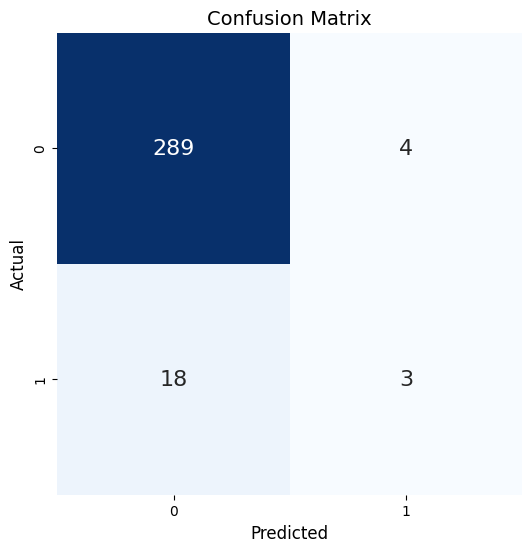

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


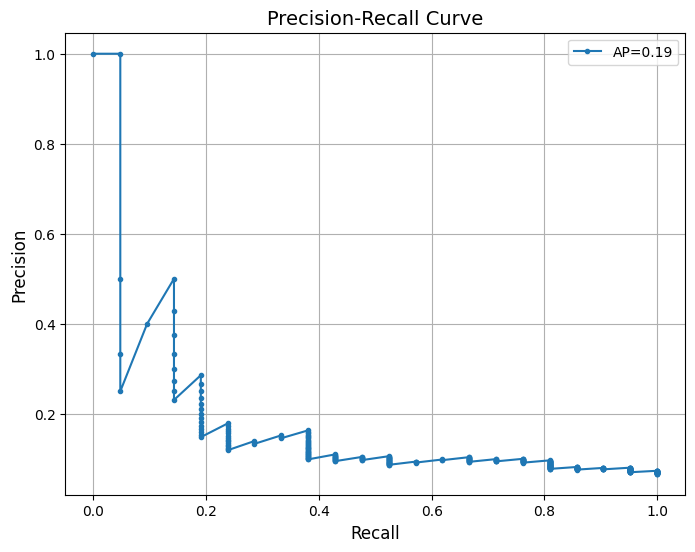

In [35]:
print("\n Evaluating model...")

# Load best model if available
if os.path.exists('best_model.h5'):
    model.load_weights('best_model.h5')
    print(" Loaded best model weights")

# Evaluate
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\n Evaluation Metrics:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            cbar=False, annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# Precision-Recall curve
y_scores = model.predict(X_test)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, marker='.', label=f'AP={avg_precision:.2f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend()
plt.grid()
plt.show()

**Visualize Training Progress**


 Visualizing training progress...


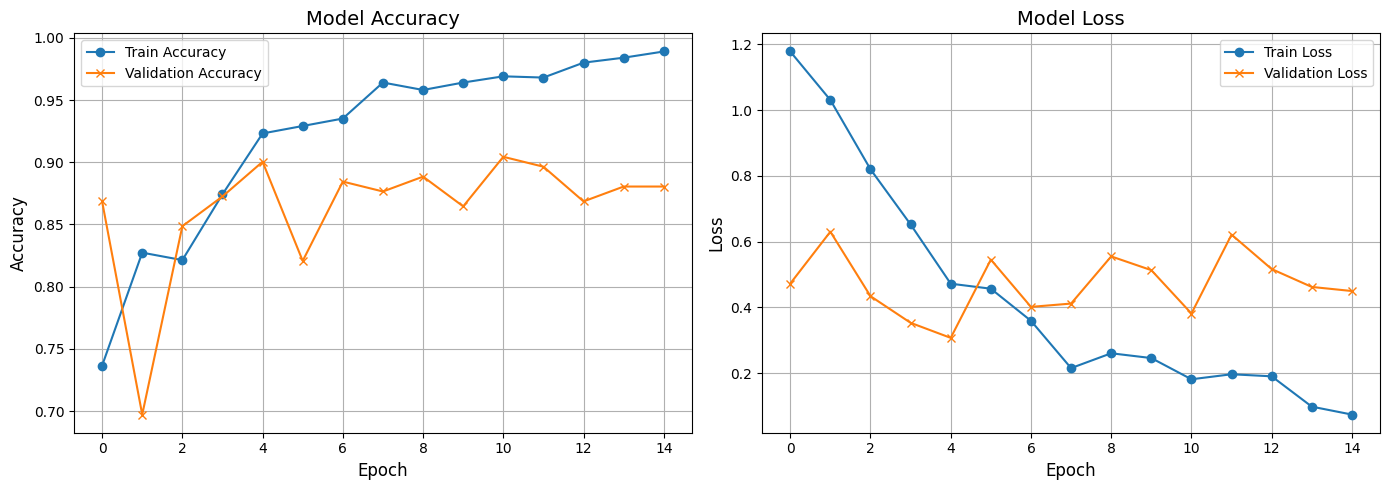

In [36]:
print("\n Visualizing training progress...")

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Make Predictions**

In [37]:
print("\n Making predictions...")

def predict_quality(input_data=None, verbose=1):
    """Make quality prediction on new data"""
    if input_data is None:
        if verbose:
            print(" No input provided. Using random data for demonstration.")
        input_data = np.random.rand(X_train.shape[1])

    # Ensure correct shape and scale
    input_data = np.array(input_data).reshape(1, -1)
    input_scaled = scaler.transform(input_data)

    # Predict with timing
    start_time = time.time()
    prediction = model.predict(input_scaled, verbose=0)
    inference_time = (time.time() - start_time) * 1000  # in milliseconds

    proba = prediction[0][0]

    if verbose:
        print("\n Prediction Results:")
        print(f"Prediction Probability: {proba:.4f}")
        print(f"Inference Time: {inference_time:.2f} ms")

        if proba > 0.5:
            print(f" Defective product (Confidence: {proba:.2%})")
        else:
            print(f" Good quality product (Confidence: {1-proba:.2%})")

    return proba, inference_time

# Example prediction with timing
sample_data = np.random.rand(X_train.shape[1])
proba, inference_time = predict_quality(sample_data)


 Making predictions...

 Prediction Results:
Prediction Probability: 0.0000
Inference Time: 81.72 ms
 Good quality product (Confidence: 100.00%)


**Save Model & Artifacts**

In [38]:
print("\n Saving model artifacts...")

def save_artifacts(save_dir='model_artifacts'):
    """Save model, scaler, and metadata using modern formats"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save model in modern Keras format (.keras)
    model.save(f'{save_dir}/secom_model.keras')

    # Save scaler
    import joblib
    joblib.dump(scaler, f'{save_dir}/scaler.pkl')

    # Save metadata with additional info
    metadata = {
        'input_shape': X_train.shape[1],
        'class_names': ['Good', 'Defective'],
        'threshold': 0.5,
        'created_at': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'performance': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall
        }
    }

    import json
    with open(f'{save_dir}/metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f" Artifacts saved to '{save_dir}' directory")
    print(f"Model saved as modern Keras format (.keras)")

save_artifacts()


 Saving model artifacts...
 Artifacts saved to 'model_artifacts' directory
Model saved as modern Keras format (.keras)


**Real-Time Monitoring (Practical Implementation)**

In [39]:
print("\n Practical implementation for real-time monitoring:")

# First let's create a test CSV file to simulate sensor input
test_csv_path = 'test_sensor_data.csv'
pd.DataFrame(np.random.rand(5, X_train.shape[1])).to_csv(test_csv_path, index=False)

def real_time_monitoring(file_path=None, sample_interval=1):
    """Simulate real-time monitoring from sensor data"""
    print("\nStarting real-time monitoring simulation...")
    print(f"Monitoring {'file: ' + file_path if file_path else 'random data'}")

    if file_path:
        try:
            sensor_data = pd.read_csv(file_path).values
            print(f"Loaded {len(sensor_data)} samples")
        except Exception as e:
            print(f"Error loading file: {e}")
            return
    else:
        sensor_data = np.random.rand(10, X_train.shape[1])

    for i, sample in enumerate(sensor_data):
        print(f"\nSample {i+1}/{len(sensor_data)}")
        proba, inference_time = predict_quality(sample)

        if proba > 0.5:
            print(" ALERT: Defective product detected - triggering action")
        else:
            print(" Product within quality standards")

        time.sleep(sample_interval)

# Run the simulation (use file_path=test_csv_path to test with file)
real_time_monitoring(file_path=None, sample_interval=0.5)


 Practical implementation for real-time monitoring:

Starting real-time monitoring simulation...
Monitoring random data

Sample 1/10

 Prediction Results:
Prediction Probability: 0.0000
Inference Time: 76.41 ms
 Good quality product (Confidence: 100.00%)
 Product within quality standards

Sample 2/10

 Prediction Results:
Prediction Probability: 0.0000
Inference Time: 79.87 ms
 Good quality product (Confidence: 100.00%)
 Product within quality standards

Sample 3/10

 Prediction Results:
Prediction Probability: 0.0000
Inference Time: 78.03 ms
 Good quality product (Confidence: 100.00%)
 Product within quality standards

Sample 4/10

 Prediction Results:
Prediction Probability: 0.0000
Inference Time: 76.60 ms
 Good quality product (Confidence: 100.00%)
 Product within quality standards

Sample 5/10

 Prediction Results:
Prediction Probability: 0.0000
Inference Time: 78.04 ms
 Good quality product (Confidence: 100.00%)
 Product within quality standards

Sample 6/10

 Prediction Results: